#### Data Processing

In [10]:
# Imports and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.integrate import trapezoid
from scipy.stats import skew, kurtosis

fs = 250 
new_data = np.load("hillary-trial_2.npy", allow_pickle=True)
df = pd.DataFrame(new_data)

print(f"Data Shape: {df.shape}")
df

Data Shape: (34013, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,2502.255440,986.226021,8443.326765,11662.559111,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,56.0,674.0,1.741475e+09
1,2387.367474,971.697387,8441.873901,11647.337573,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,57.0,672.0,1.741475e+09
2,2448.611253,935.107581,8397.371578,11621.253088,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,56.0,674.0,1.741475e+09
3,2574.004540,945.389383,8391.247200,11634.127692,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,57.0,673.0,1.741475e+09
4,2537.034754,984.147308,8436.911814,11664.995452,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,56.0,673.0,1.741475e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
34008,2262.644739,955.559427,7962.183113,11473.441002,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,55.0,673.0,1.741475e+09
34009,2339.847665,908.129025,7900.827575,11432.716123,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,57.0,672.0,1.741475e+09
34010,2375.789270,963.226076,7957.086916,11488.640188,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,55.0,674.0,1.741475e+09
34011,2314.634897,1018.568995,8027.874890,11539.736276,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,57.0,673.0,1.741475e+09


In [11]:
# Labeling columns

# onset and offset of artifacts
df['onset'] = (df[9].shift(1) < 30) & (df[9] >= 30) # First onset is jaw clench and offset is jawclench
df['offset'] = (df[9].shift(-1) < 30)& (df[9] >= 30) # Anastasyas code

num_channels = 11  
column_names = [f"EEG_{i}" for i in range(1, 9)]  # 8 EEG channels
column_names += [f"AUX_{i}" for i in range(1, 4)]  # 3 AUX channels
column_names += ["Timestamp", "Onset", "Offset"]  # Add Onset and Offset

df.columns = column_names 

# Extract EEG channels
selected_eeg_channels = ["EEG_1", "EEG_2", "EEG_3", "EEG_4"]
eeg_data = df[selected_eeg_channels]

# Extract AUX channels
aux_channels = ["AUX_1", "AUX_2", "AUX_3"]
aux_data = df[aux_channels]

# Extract timestamps
timestamps = df["Timestamp"]

print(f"EEG Data Shape: {eeg_data.shape}")
print(f"Timestamps Shape: {timestamps.shape}")
print(f"AUX Channel Shape: {aux_data.shape}") # Make sure these are correctly labeled

df

EEG Data Shape: (34013, 4)
Timestamps Shape: (34013,)
AUX Channel Shape: (34013, 3)


,EEG_1,EEG_2,EEG_3,EEG_4,EEG_5,EEG_6,EEG_7,EEG_8,AUX_1,AUX_2,AUX_3,Timestamp,Onset,Offset
0,2502.255440,986.226021,8443.326765,11662.559111,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,56.0,674.0,1.741475e+09,False,False
1,2387.367474,971.697387,8441.873901,11647.337573,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,57.0,672.0,1.741475e+09,False,False
2,2448.611253,935.107581,8397.371578,11621.253088,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,56.0,674.0,1.741475e+09,False,False
3,2574.004540,945.389383,8391.247200,11634.127692,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,57.0,673.0,1.741475e+09,False,False
4,2537.034754,984.147308,8436.911814,11664.995452,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,56.0,673.0,1.741475e+09,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34008,2262.644739,955.559427,7962.183113,11473.441002,-187500.022352,-187500.022352,-187500.022352,-187500.022352,339.0,55.0,673.0,1.741475e+09,False,False
34009,2339.847665,908.129025,7900.827575,11432.716123,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,57.0,672.0,1.741475e+09,False,False
34010,2375.789270,963.226076,7957.086916,11488.640188,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,55.0,674.0,1.741475e+09,False,False
34011,2314.634897,1018.568995,8027.874890,11539.736276,-187500.022352,-187500.022352,-187500.022352,-187500.022352,340.0,57.0,673.0,1.741475e+09,False,False


<Axes: >

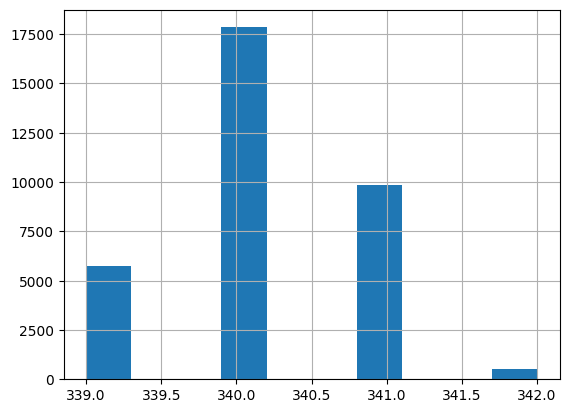

In [13]:
df['AUX_1'].hist()

Onset
False    43927
Name: count, dtype: int64

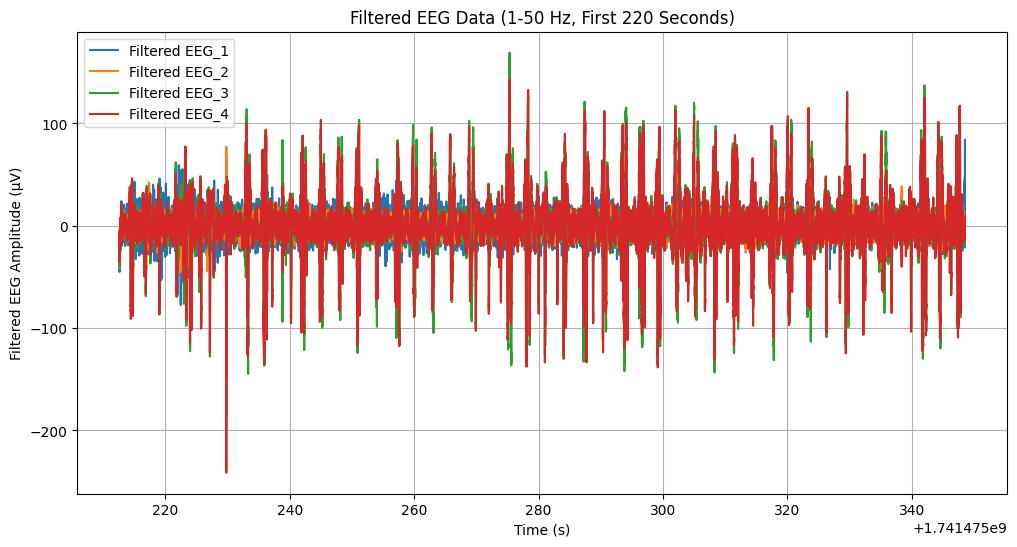

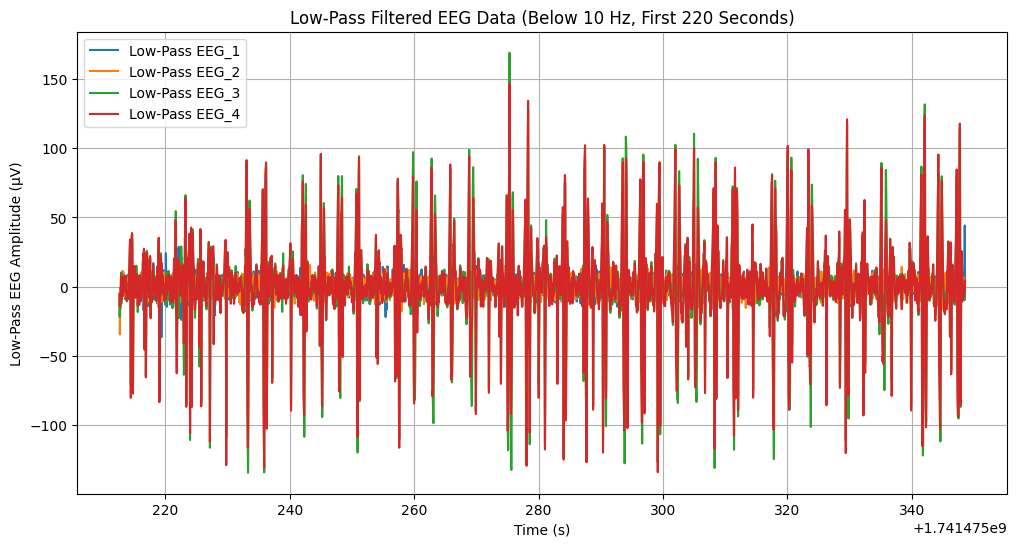

In [14]:
# Applying Bandpass and Lowpass Filters

time_window = 220 
start_idx = 0  
end_idx = int(time_window * fs)

# Bandpass filter function (1-50 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

filtered_eeg = eeg_data.apply(lambda x: bandpass_filter(x, 1, 50, fs))
filtered_eeg_segment = filtered_eeg.iloc[start_idx:end_idx, :]

time_segment = timestamps[start_idx:end_idx]  # Corresponding time segment for x-axis

plt.figure(figsize=(12, 6))
for i, col in enumerate(filtered_eeg_segment.columns):
    plt.plot(time_segment, filtered_eeg_segment[col], label=f"Filtered {col}")

plt.xlabel("Time (s)")
plt.ylabel("Filtered EEG Amplitude (µV)")
plt.title(f"Filtered EEG Data (1-50 Hz, First {time_window} Seconds)")
plt.legend()
plt.grid(True)
plt.show()

# Lowpass filter for slow drifts (Below 1 Hz) (I dont think this matters for the double blinks)
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data, axis=0)

lowpass_filtered_eeg = filtered_eeg.apply(lambda x: lowpass_filter(x, 10, fs))
lowpass_filtered_eeg_segment = lowpass_filtered_eeg.iloc[start_idx:end_idx, :]

plt.figure(figsize=(12, 6))
for i, col in enumerate(lowpass_filtered_eeg_segment.columns):
    plt.plot(time_segment, lowpass_filtered_eeg_segment[col], label=f"Low-Pass {col}")

plt.xlabel("Time (s)")
plt.ylabel("Low-Pass EEG Amplitude (µV)")
plt.title(f"Low-Pass Filtered EEG Data (Below 10 Hz, First {time_window} Seconds)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Order of artifact cue for each trial (will only focus on trial_3)
artifacts = np.load("trials.npy")
df_artifacts = pd.DataFrame(artifacts)
df_artifacts

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,jaw_clench,jaw_clench,jaw_clench,jaw_clench_blink,double_blink,double_blink,jaw_clench_blink,jaw_clench,blink_hard,jaw_clench,...,double_blink,blink_hard,jaw_clench,double_blink,jaw_clench_blink,jaw_clench,jaw_clench,double_blink,jaw_clench_blink,blink_hard
1,jaw_clench_blink,jaw_clench,blink_hard,jaw_clench_blink,blink_hard,double_blink,blink_hard,jaw_clench,jaw_clench_blink,jaw_clench_blink,...,double_blink,blink_hard,blink_hard,jaw_clench_blink,blink_hard,blink_hard,blink_hard,jaw_clench,blink_hard,blink_hard
2,blink_hard,double_blink,jaw_clench_blink,double_blink,double_blink,double_blink,double_blink,jaw_clench_blink,double_blink,jaw_clench_blink,...,double_blink,double_blink,jaw_clench_blink,blink_hard,jaw_clench,jaw_clench_blink,jaw_clench_blink,blink_hard,jaw_clench_blink,jaw_clench


In [16]:
filtered_eeg

,EEG_1,EEG_2,EEG_3,EEG_4
0,-10.836802,-4.595456,-5.230469,-5.832637
1,-45.079254,-32.123695,-29.704619,-28.419437
2,-41.035187,-41.073049,-40.160794,-35.241192
3,-16.729245,-31.701366,-33.851130,-26.525779
4,-11.816271,-21.763932,-22.666081,-16.477435
...,...,...,...,...
34008,32.412954,-3.772534,-11.771878,-8.370832
34009,60.458861,-10.654448,-21.203558,-11.841029
34010,84.206022,-6.520190,-18.159099,-4.712356
34011,64.762814,0.688075,-5.981009,3.792794


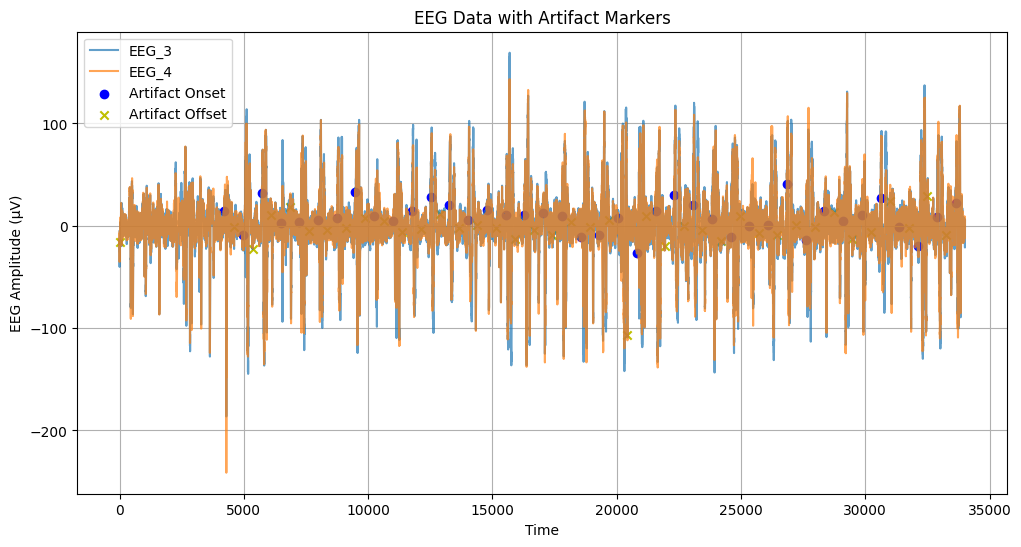

In [17]:
# Data showing onset and offset of double blink artifact

# Extract onset and offset indices for double blink
onset_indices = df[df['Onset'] == True].index
offset_indices = df[df['Offset'] == True].index

# Data with artifact markers
plt.figure(figsize=(12, 6))
for i, col in enumerate(filtered_eeg.columns[2:]):
    plt.plot(filtered_eeg[col], label=f"{col}", alpha=0.7)

# Overlay artifact markers for double blink
plt.scatter(onset_indices, filtered_eeg.iloc[onset_indices]['EEG_3'], color='b', label="Artifact Onset", marker='o')
plt.scatter(offset_indices, filtered_eeg.iloc[offset_indices]['EEG_3'], color='y', label="Artifact Offset", marker='x')

plt.xlabel("Time")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Data with Artifact Markers")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Artifact labeling for double blink

# Trial positions that correspond to double blinks IN TRIAL 3
double_blink_positions = df_artifacts.iloc[1] == "double_blink"

# All detected onsets from the EEG DataFrame
all_onsets = df[df["Onset"]].index

# Extract corresponding EEG onset indices
double_blink_onsets = all_onsets[double_blink_positions.values]

print("Double Blink Onsets:", double_blink_onsets) 

Double Blink Onsets: Index([7987, 12512, 14777, 19303, 26843], dtype='int64')


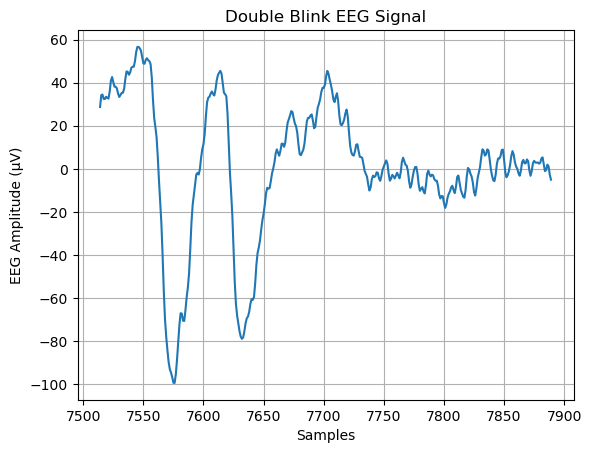

In [276]:
# First detected double blink onset and offset

onset_idx = double_blink_onsets[0] 
offset_idx = onset_idx + int(1.5 * fs)  # Assuming 1.5 s window

offset_idx = min(offset_idx, len(df) - 1)

filtered_eeg['EEG_3'].loc[onset_idx: offset_idx].plot(kind='line', title="Double Blink EEG Signal")
plt.xlabel("Samples")
plt.ylabel("EEG Amplitude (µV)")
plt.grid(True)
plt.show()

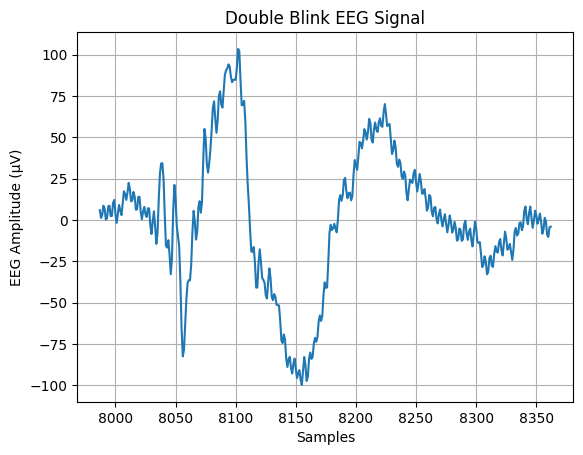

In [19]:
# First detected double blink onset and offset

onset_idx = double_blink_onsets[0] 
offset_idx = onset_idx + int(1.5 * fs)  # Assuming 1.5 s window

offset_idx = min(offset_idx, len(df) - 1)

filtered_eeg['EEG_3'].loc[onset_idx: offset_idx].plot(kind='line', title="Double Blink EEG Signal")
plt.xlabel("Samples")
plt.ylabel("EEG Amplitude (µV)")
plt.grid(True)
plt.show()

#### Starting on Classification

In [277]:
# Epoch extraction, around each double blink (pos class) and non-blink (neg class)

epoch_window_samples = int(1 * fs)  # 1 s before and after onset
epochs = []
labels = []  # 1 = double blink, 0 = non-blink

# Extract double blink epochs using double_blink_onsets
# assuming indexes are the same for onset and df_artifact
for onset in double_blink_onsets:
    start_epoch = max(onset - epoch_window_samples, 0)
    end_epoch = min(onset + epoch_window_samples, len(filtered_eeg)) # setting window
    epoch = filtered_eeg.iloc[start_epoch:end_epoch].values # extract data
    if epoch.shape[0] == 2 * epoch_window_samples:
        epochs.append(epoch)
        labels.append(1)

# Extract non-blink epochs, randomly sampling
num_positive = len(epochs)
possible_indices = list(set(range(epoch_window_samples, len(filtered_eeg) - epoch_window_samples)) - set(double_blink_onsets))
random_indices = random.sample(possible_indices, num_positive) # randomizing cfreates balanced dataset for model
for idx in random_indices:
    epoch = filtered_eeg.iloc[idx - epoch_window_samples: idx + epoch_window_samples].values
    if epoch.shape[0] == 2 * epoch_window_samples:
        epochs.append(epoch)
        labels.append(0)

epochs = np.array(epochs)
labels = np.array(labels)
print("Epochs shape:", epochs.shape)
print("Labels distribution:", np.unique(labels, return_counts=True))

Epochs shape: (24, 500, 4)
Labels distribution: (array([0, 1]), array([12, 12]))


In [278]:
epochs

array([[[ -7.56835835,   6.29112956,   9.41232379,   6.24323945],
        [  7.74774699,  15.98714886,  12.78492506,  10.13492501],
        [ 15.48644618,  16.53837388,   9.70514811,   5.13013172],
        ...,
        [  9.66327177,  11.98733149,  -1.834359  ,  -0.77973169],
        [  7.8583167 ,  11.4738918 ,  -3.0608532 ,  -1.4392846 ],
        [  4.84556629,   8.11924648,  -4.43009896,  -4.22163308]],

       [[-15.27412473,  -7.20661402,  30.6725433 ,  28.24376329],
        [ -7.83132191,  -1.55509114,  32.95787981,  31.45232423],
        [ -2.94286824,   0.15951637,  30.42831256,  28.38488875],
        ...,
        [ -7.7366708 ,   2.42992046,   7.84180889,  11.13240356],
        [ -8.55778993,   4.20064907,   5.67966399,   8.46708621],
        [ -5.95014916,   4.86671963,   3.36780112,   3.75650185]],

       [[  3.46694318,   3.59701549,   5.70540809,   5.54428013],
        [  9.5437439 ,   6.23805976,   8.25527438,   9.20038201],
        [ 12.83159224,   8.80391208,  10.92887

In [279]:
# Feature extraction from epochs: 
# time-domain (mean, variance) and frequency-domain (bandpower in alpha and beta bands) features
 
def compute_bandpower(signal, fs, band):
    freqs, psd = welch(signal, fs, nperseg=256)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return trapezoid(psd[idx_band], freqs[idx_band])

# added a counting peaks function to differentiate between double and single eye blinks
def count_peaks(signal, height=None, distance=None):
    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return len(peaks)

# adding five more features: min, median, skewness, kurtosis, and num of peaks
def extract_features(epoch, fs):
    feats = []
    for ch in range(epoch.shape[1]):
        sig = epoch[:, ch]
        mean_val = np.mean(sig)
        var_val = np.var(sig)
        min_val = np.min(sig)  # new feature: minimum
        median_val = np.median(sig)  # new feature: median
        skewness = skew(sig)  # new feature: skewness
        kurt = kurtosis(sig)  # new feature: kurtosis
        alpha_bp = compute_bandpower(sig, fs, (8, 13))
        beta_bp = compute_bandpower(sig, fs, (13, 30))
        peak_count = count_peaks(sig)  # new feature: number of peaks
        feats.extend([mean_val, var_val, min_val, median_val, skewness, kurt, alpha_bp, beta_bp, peak_count])
    return np.array(feats)

feature_list = [extract_features(epoch, fs) for epoch in epochs]
features = np.array(feature_list)
print("Features shape:", features.shape)
# shape should be 4 eeg channels x the 9 features

# Standardizing the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

Features shape: (24, 36)


In [280]:
# Training SVM classifier

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)

# Trying different SVM kernels
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
# for kernel in kernels:
accs = []
for i in range(500):
    classifier = SVC(kernel='sigmoid', probability=True)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, stratify=labels)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)
    # print(f"SVM ({kernel} kernel) Accuracy: {acc * 100:.2f}%")
    # print("Confusion Matrix:")
    # print(confusion_matrix(y_test, y_pred))

accs = np.array(accs)
print(f"Mean Accuracy: {np.mean(accs) * 100:.2f}%")

Mean Accuracy: 66.90%


In [237]:
# Other classifiers to try:
# Random Forest - for non linear decision boundaries
# Neural Networks - if there's enough data, try MLP

In [238]:
# Random forest classification

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# doesnt perform signficantly better than SVM (performs pretty much the same)

Random Forest Accuracy: 50.00%
Confusion Matrix:
[[1 1]
 [1 1]]


In [239]:
df.shape

(34969, 14)

In [240]:
df_trying = df.iloc[0:(int(200*fs)+1)]

In [241]:
df_trying = df_trying[[11, 2, 3, 9]]
df_trying[11] = np.array(range(0,len(df_trying)))/fs

KeyError: "None of [Index([11, 2, 3, 9], dtype='int64')] are in the [columns]"

In [ ]:
df_trying

,11,2,3,9
0,0.000,8137.621956,-1131.579415,128.0
1,0.004,8161.359508,-1097.224784,128.0
2,0.008,8126.468435,-1139.804857,127.0
3,0.012,8102.641476,-1177.847526,128.0
4,0.016,8140.214758,-1135.490970,127.0
...,...,...,...,...
35983,143.932,7212.125625,-1616.947546,127.0
35984,143.936,7260.807724,-1553.692109,127.0
35985,143.940,7268.787297,-1535.207216,128.0
35986,143.944,7224.262622,-1593.008827,127.0


In [ ]:
df_trying = df[['Timestamp', 'EEG_3', 'EEG_4', 'Onset', 'Offset']]
df_trying = df_trying.iloc[0:(int(200*fs)+1)]
df_trying['Timestamp'] = np.array(range(0,len(df_trying)))/fs

In [ ]:
blinks_qt = np.load('tblinks.npy')

In [ ]:
idx = 3
start = blinks_qt[idx][0]
stop = blinks_qt[idx][-1]

Trying simple classfier

In [281]:
onset_idx = double_blink_onsets[0] 
offset_idx = onset_idx + int(1.5 * fs)

offset_idx = min(offset_idx, len(df) - 1)

# filtered_eeg['EEG_3'].loc[onset_idx: offset_idx].plot(kind='line', title="Double Blink EEG Signal")
# plt.scatter(onset_indices, filtered_eeg.iloc[onset_indices]['EEG_3'], color='b', label="Artifact Onset", marker='o')

In [282]:
def find_max_min_pattern(max_peaks, min_peaks):
    # Create a list to store the windows that match the pattern
    pattern_windows = []

    # Iterate through the max peaks and check if the pattern occurs
    for i in range(len(max_peaks) - 2):  # We need at least 5 peaks for a complete pattern
        # Define the candidate window of 5 peaks (max, min, max, min, max)
        candidate_max1 = max_peaks[i]
        candidate_min1 = min_peaks[i] if i < len(min_peaks) else None
        candidate_max2 = max_peaks[i + 1]
        candidate_min2 = min_peaks[i + 1] if i + 1 < len(min_peaks) else None
        candidate_max3 = max_peaks[i + 2]

        # print((candidate_max1, candidate_min1, candidate_max2, candidate_min2, candidate_max3))

        # Check if we have a valid pattern: max, min, max, min, max
        if (candidate_min1 is not None and candidate_max1 < candidate_min1 and
            candidate_max2 > candidate_min1 and candidate_min2 is not None and
            candidate_max2 < candidate_min2 and candidate_max3 > candidate_min2):
            # If the pattern matches, store the start and end indices of the window
            pattern_windows += [candidate_max1, candidate_min1, candidate_max2, candidate_min2, candidate_max3]

    return pattern_windows

6.439201694795944
21.349061297675732
23.24490032755054
11.189628569983093
5.7193473469932545
16.395632771359654
18.460255931603996
10.9685655538222


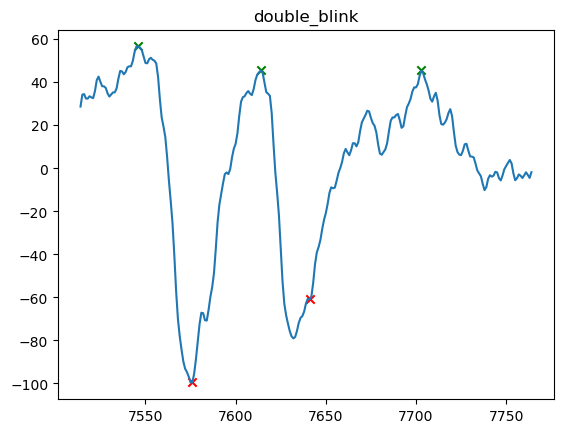

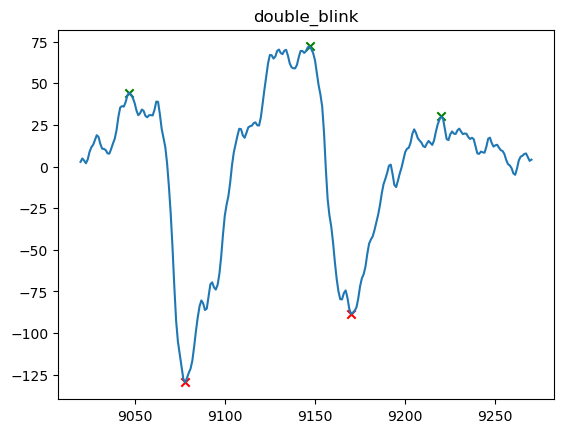

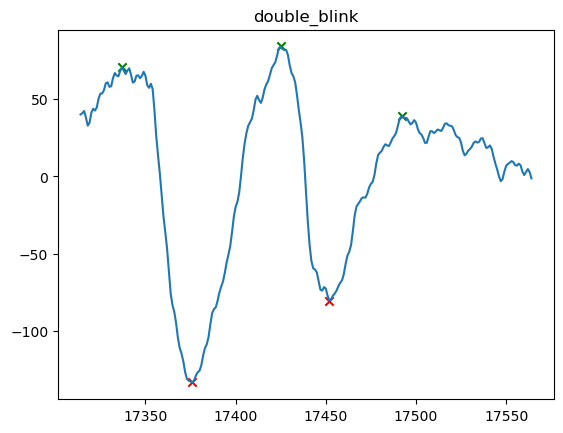

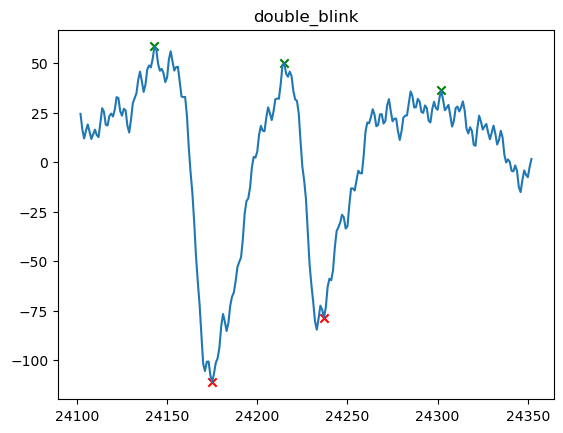

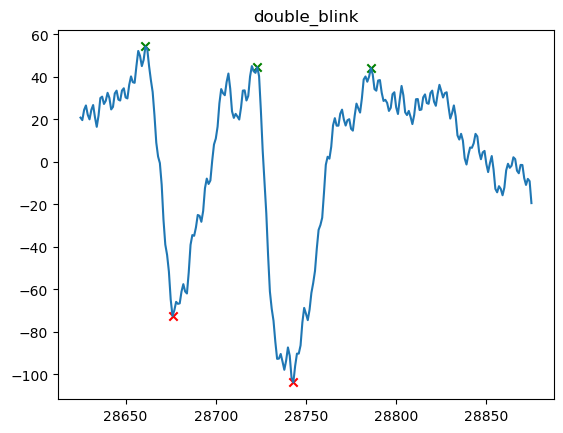

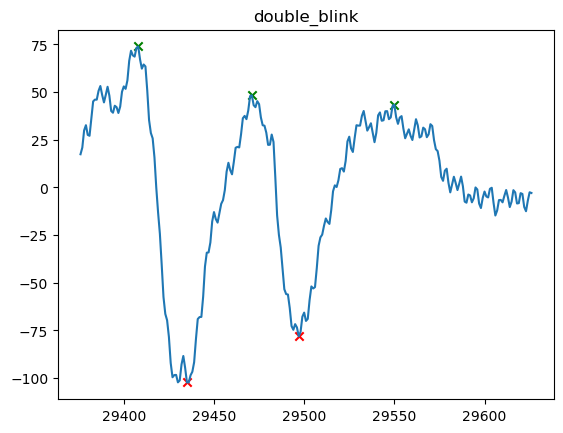

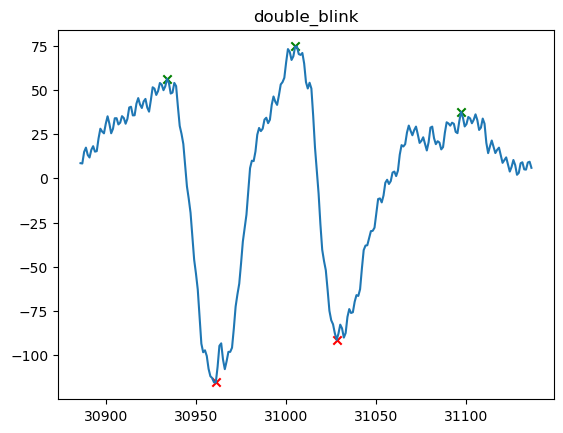

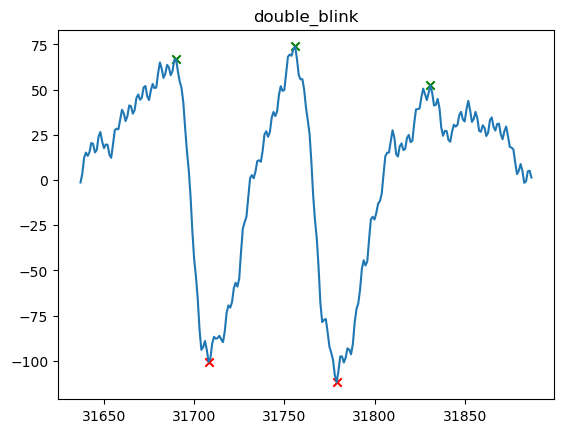

In [ ]:
# onset_idx = double_blink_onsets[5] 

for i, onset_idx in enumerate(all_onsets):
    offset_idx = onset_idx + int(1 * fs)

    offset_idx = min(offset_idx, len(df) - 1)

    signal = filtered_eeg['EEG_3'].loc[onset_idx: offset_idx]
    peaks, _ = find_peaks(-1*signal, height=40, distance=60)
    max_peaks, _ = find_peaks(signal, height=20, distance=60)
    potential_peaks = signal.index[0] + peaks
    potential_max_peaks = signal.index[0] + max_peaks

    ground_points = find_max_min_pattern(max_peaks, peaks)

    if len(ground_points) > 1 and signal[potential_max_peaks].std() < 45:
        print(signal[potential_max_peaks].std())
        fig, ax = plt.subplots()    
        filtered_eeg['EEG_3'].loc[onset_idx: offset_idx].plot(kind='line', title=f"{artifacts[1][i]}")
        plt.scatter(potential_peaks, signal[potential_peaks], color='r', label="Potential Peaks", marker='x')
        plt.scatter(potential_max_peaks, signal[potential_max_peaks], color='g', label="Potential Peaks", marker='x')

In [287]:
sum(artifacts[1] == 'double_blink')

12

In [152]:
all_onsets = np.array(all_onsets)
all_offset = all_onsets + int(1 * fs)
all_offset = np.array([min(i, len(df) - 1) for i in all_offset])

In [169]:
all_artifacts = []
for i, j in zip(all_onsets, all_offset):
    all_artifacts.append(filtered_eeg['EEG_3'][i: j].to_numpy())#.plot(kind='line', title="Double Blink EEG Signal")

In [ ]:
all_artifacts = np.array(all_artifacts)


(40, 250)

In [176]:
corr_m = np.corrcoef(all_artifacts, all_artifacts)

<Axes: >

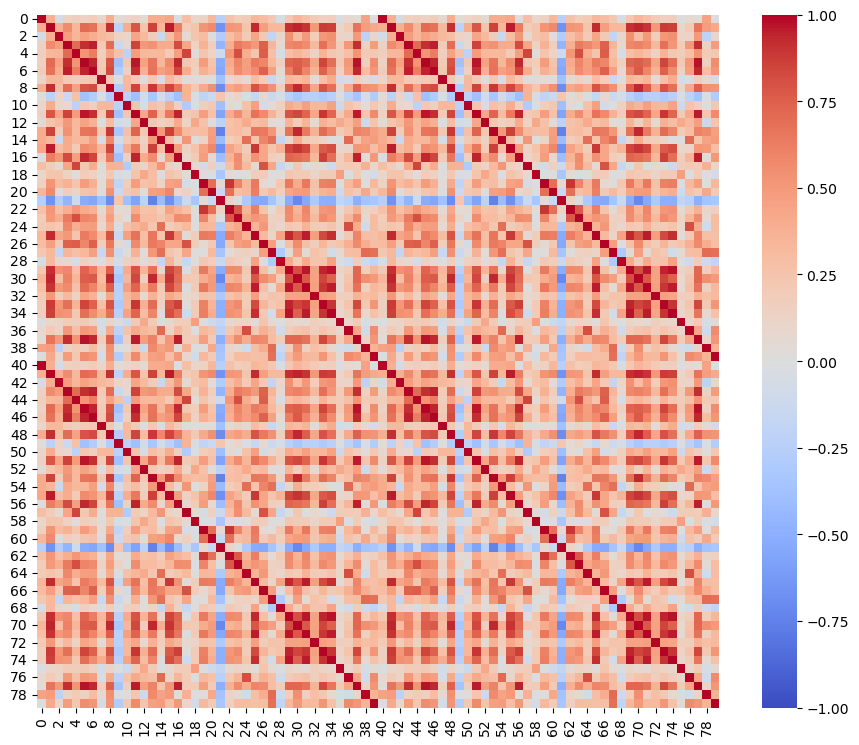

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr_m, annot=False, vmax=1, vmin=-1, cmap='coolwarm')

<Axes: >

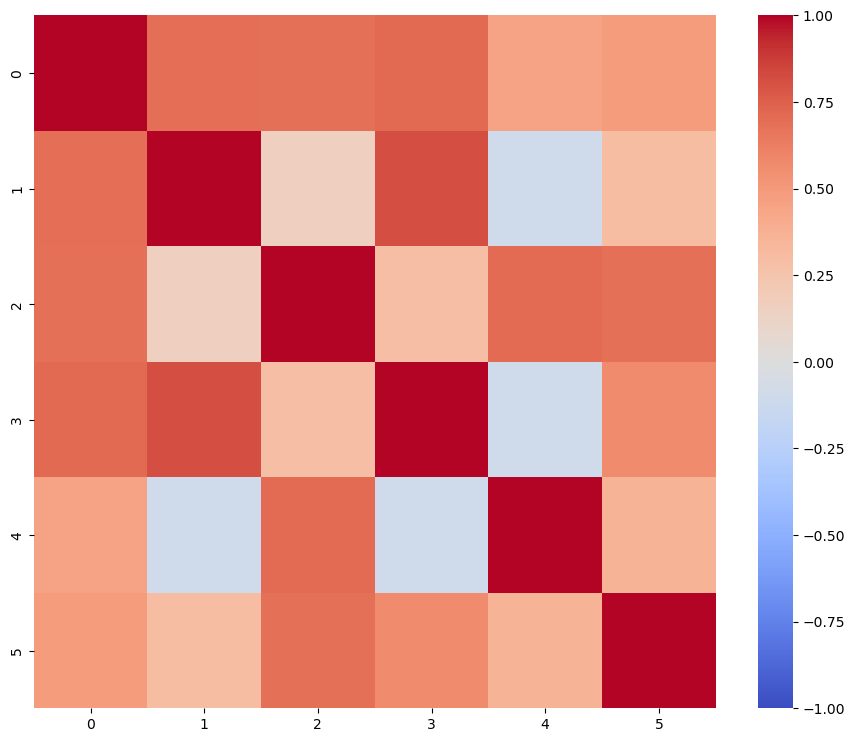

In [206]:
double_blink_onsets
double_blink_offset = double_blink_onsets + int(1 * fs)
double_blink_offset= np.array([min(i, len(df) - 1) for i in double_blink_offset])

all_artifacts = []
for i, j in zip(double_blink_onsets, double_blink_offset):
    all_artifacts.append(filtered_eeg['EEG_3'][i: j].to_numpy())

all_artifacts = np.array(all_artifacts)

corr_m = np.corrcoef(all_artifacts)

# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr_m, annot=False, vmax=1, vmin=-1, cmap='coolwarm')